In [1]:
# importing neccesary libraries

import cv2
import numpy as np
import mediapipe as mp
import json

In [2]:
# Setting up mediapipe for predictions

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [3]:
# Using our previous etl script which is used to generate all the neccesary landmarks

pose_x = []
pose_y = []
rh_x = []
rh_y = []
lh_x = []
lh_y = []

def etl(path,wr_path):
    cap = cv2.VideoCapture(path)

    # Properties
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = cap.get(cv2.CAP_PROP_FPS)
                                                                                            
    mp_holistic = mp.solutions.holistic # Holistic model

    # Video Writer
    posepath = wr_path+ r'/posevid.mp4'
    video_writer = cv2.VideoWriter(posepath , cv2.VideoWriter_fourcc('m','p','4','v'), fps, (width, height), isColor=True)                         
    cap = cv2.VideoCapture(path)



    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        for frame_idx in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            # Read feed
            ret, frame = cap.read()

            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            # print(results)
            
            pose_xi = []
            pose_yi = []
            if results.pose_landmarks: 
                for i in range(33):
                    results.pose_landmarks.landmark[i].x = results.pose_landmarks.landmark[i].x * image.shape[0]
                    results.pose_landmarks.landmark[i].y = results.pose_landmarks.landmark[i].y * image.shape[1]
                    pose_xi.append(results.pose_landmarks.landmark[i].x)
                    pose_yi.append(results.pose_landmarks.landmark[i].y)
            else:
                for i in range(33):
                    pose_xi.append(int(0))
                    pose_yi.append(int(0))

            pose_x.append(pose_xi)
            pose_y.append(pose_yi)

            rh_xi = []
            rh_yi = []   
            if results.right_hand_landmarks:
                for i in range(21):
                    results.right_hand_landmarks.landmark[i].x = results.right_hand_landmarks.landmark[i].x * image.shape[0]
                    results.right_hand_landmarks.landmark[i].y = results.right_hand_landmarks.landmark[i].y * image.shape[1]
                    rh_xi.append(results.right_hand_landmarks.landmark[i].x)
                    rh_yi.append(results.right_hand_landmarks.landmark[i].y)
            else:
                for i in range(21):
                    rh_xi.append(int(0))
                    rh_yi.append(int(0))

            rh_x.append(rh_xi)
            rh_y.append(rh_yi)


            lh_xi = []
            lh_yi = []
                        
            if results.left_hand_landmarks:

                for i in range(21):
                    results.left_hand_landmarks.landmark[i].x = results.left_hand_landmarks.landmark[i].x * image.shape[0]
                    results.left_hand_landmarks.landmark[i].y = results.left_hand_landmarks.landmark[i].y * image.shape[1]
                    lh_xi.append(results.left_hand_landmarks.landmark[i].x)
                    lh_yi.append(results.left_hand_landmarks.landmark[i].y)
            else:
                for i in range(21):
                    lh_xi.append(int(0))
                    lh_yi.append(int(0))

            lh_x.append(lh_xi)
            lh_y.append(lh_yi)

            # Show to screen
            # cv2.imshow('OpenCV Feed',image)

            video_writer.write(image)

            # Break gracefully
            if cv2.waitKey(5) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()
        # Release video writer
        video_writer.release()

In [4]:
# Helper functions created to make code easier and readable

# Finding mean (in our case it is used to find each points for the centroid)
def avg(lst):
    return sum(lst) / len(lst)

# Square the values in the given list
def sq(x):
    return np.square(np.array(x)).tolist()

# Root values of the list
def sqrt(x):
    return np.sqrt(np.array(x)).tolist()

# Hand Distance parameter which is used to detect similar frames from the video
def hand_dist(lh_x,lh_y,rh_x,rh_y,alpha):
    hd = []
    for i in range(len(lh_x)-1):
        lx = avg(lh_x[i + 1]) - avg(lh_x[i])
        ly = avg(lh_y[i + 1]) - avg(lh_y[i])
        rx = avg(rh_x[i + 1]) - avg(rh_x[i])
        ry = avg(rh_y[i + 1]) - avg(rh_y[i])
        hd.append(int(alpha)*(max(sqrt(sq(lx)+sq(ly)),sqrt(sq(rx)+sq(ry)))))
    return hd

# Hand height parameter is used to remove unwanted frames
def hand_height(lh_y,rh_y,beta):
    hh= []
    for i in range(len(lh_y)-1):
        hh.append(int(beta)*(min(avg(lh_y[i]),avg(rh_y[i]))))
    return hh

# This variance measures the blurriness level of the grayed frame
def variance(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# This function is used to find Percentage Reduction
def perc_red(val,total):
    return 100 - ((val/total)*100)

In [5]:
# Calculating pose,left and right hand landmark estimates with help of etl function
path = 'sample_videos/sample1.mp4'
wr_path = 'vid'
etl(path,wr_path)

In [6]:
# Calculating both Hand Distance and Hand Height parameters
h_di = hand_dist(lh_x,lh_y,rh_x,rh_y,1)
h_hi = hand_height(lh_y,rh_y,1)

# We can observe that both hand_height and hand_dist parameters are of same length i.e, initial/total frames
print(len(h_hi))
print(len(h_di))

261
261


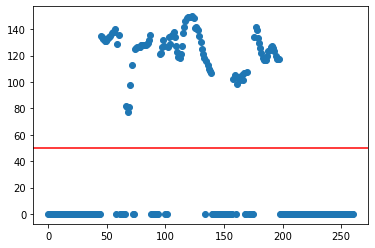

In [7]:
import matplotlib.pyplot as plt

# Analyzing the hand height parameter by scatter plotting values
x = np.arange(0,len(h_hi))
plt.scatter(x,h_hi)

# drawing a threshold line
plt.axhline(y = 50, color = 'r', linestyle = '-')

We can actually see that most of the frames in the video having hand height of value zero. So removing the frames with threshold zero will significantly reduce the frames and we can remove all the unwanted frames from the begining, middle and end of the video.

In [8]:
h_hi_th = [x for x in h_hi if x > 0]
len(h_hi_th)
# We have reduced the frames value from 261 to 109

109

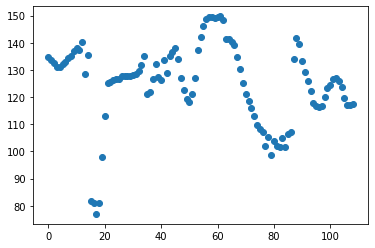

In [9]:
# Plotting hand height values after thresholding
import matplotlib.pyplot as plt
x = np.arange(0,len(h_hi_th))
plt.scatter(x,h_hi_th)
# plt.axhline(y = 50, color = 'r', linestyle = '-')

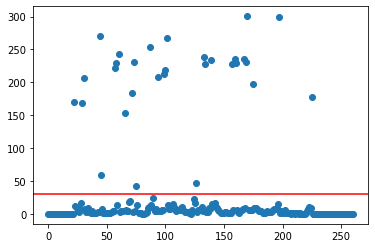

In [10]:
# Now analyzing the hand distance parameter by plotting values
x = np.arange(0,len(h_di))
plt.scatter(x,h_di)
plt.axhline(y = 30, color = 'r', linestyle = '-')

we know that hand distance parameter is used to detect similar frames by fixing some threshold like 30 will cnsider the important frames and will leave the repeated frames

In [11]:
# Thresholding values with 30
h_hi_th = [x for x in h_di if x < 30]
len(h_hi_th)

231

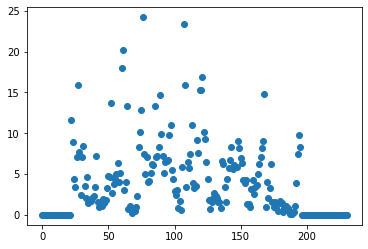

In [12]:
x = np.arange(0,len(h_hi_th))
plt.scatter(x,h_hi_th)
# plt.axhline(y = 50, color = 'r', linestyle = '-')

In [13]:
h_hi_di_th = []
for i in range(len(h_hi)):
    if(h_di[i] < 30 and h_hi[i] > 0):
        h_hi_di_th.append(x)

In this code we are applying both the thresholds and appending those frames into a list and seeing it's length

In [14]:
len(h_hi_di_th)

95

By taking these two parameters into consideration we have decreased the frames count from 261 to 95


In [15]:
# Reduced Percentage of frames
perc_red(len(h_hi_di_th),len(h_hi))

63.60153256704981

Now we are applying these parameters thresholding to the actual video and visualize the difference and saving that video

In [32]:
def kfs(path,h_hi_th,h_di_th):

    # Calculating both Hand Distance and Hand Height parameters
    h_di = hand_dist(lh_x,lh_y,rh_x,rh_y,1)
    h_hi = hand_height(lh_y,rh_y,1)
    
    post_kfs_cnt = 0
    cap = cv2.VideoCapture(path)

    # Properties
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = cap.get(cv2.CAP_PROP_FPS)
                                     
    
    # Video Writer
    f_name = path.split('/')[-1]
    savepath = 'Output/'+f_name.split('.')[0]+'_output.mp4'
    video_writer = cv2.VideoWriter(savepath , cv2.VideoWriter_fourcc(*'MP4V'), fps, (width, height), isColor=True)                         
    cap = cv2.VideoCapture(path)

    for i in range(len(h_hi)):
        # Read feed
        ret, frame = cap.read()
        # Thresholding
        if(h_di[i] < h_di_th and h_hi[i] > h_hi_th):
            # Show to screen
            # cv2.imshow('OpenCV Feed',frame)
            post_kfs_cnt+=1

            video_writer.write(frame)

        # Break gracefully
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    # Release video writer
    video_writer.release()
    per_red = perc_red(post_kfs_cnt,len(h_hi))

    # Data to be written in the json file
    dictionary = {
        "Filename" : f_name,

        "Hand_Height" : h_hi,
        "Hand_Distance" : h_di,

        "Initial_Frame_Count" : len(h_hi),
        "Post_KFS_Frame_Count" : post_kfs_cnt,

        "Percentage_Reduction" : per_red,

        "Hand_Height_Threshold_Value" : h_hi_th,
        "Hand_Distance_Threshold_Value" : h_di_th   
    }

    with open('Output/'+f_name.split('.')[0]+"_output.json", "w") as outfile:
        json.dump(dictionary, outfile)
    return

In [ ]:
path = 'sample_videos/sample1.mp4'
# Applying Key frame selection procedure
kfs(path,0,50)

In [ ]:
path = 'sample_videos/sample2.mp4'

# Calculating pose,left and right hand landmark estimates with help of etl function
etl(path,'vid')
# Applying Key frame selection procedure
kfs(path,0,50)

In [ ]:
path = 'sample_videos/sample3.mp4'

# Calculating pose,left and right hand landmark estimates with help of etl function
etl(path,'vid')
# Applying Key frame selection procedure
kfs(path,0,50)

In [ ]:
path = 'sample_videos/sample4.mp4'

# Calculating pose,left and right hand landmark estimates with help of etl function
etl(path,'vid')
# Applying Key frame selection procedure
kfs(path,0,50)

In [ ]:
path = 'sample_videos/sample5.mp4'

# Calculating pose,left and right hand landmark estimates with help of etl function
etl(path,'vid')
# Applying Key frame selection procedure
kfs(path,0,50)

In [ ]:
path = 'sample_videos/sample6.mp4'

# Calculating pose,left and right hand landmark estimates with help of etl function
etl(path,'vid')
# Applying Key frame selection procedure
kfs(path,0,50)